In [1]:
# Import ALl required Libraries
from huggingface_hub import snapshot_download
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

### Data Loading

In [2]:
# Importing Dataset
repo_path = snapshot_download(repo_id="Rianknow/creditscoring",repo_type="dataset")
print(repo_path)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

/root/.cache/huggingface/hub/datasets--Rianknow--creditscoring/snapshots/7fd77bc9b0803a6794931bf3438d3c0d3ac0232e


In [3]:
# Define the path to the downloaded dataset
base_path = "/root/.cache/huggingface/hub/datasets--Rianknow--creditscoring/snapshots/7fd77bc9b0803a6794931bf3438d3c0d3ac0232e"

In [4]:
# Paths to train and test CSV files
train_path = os.path.join(base_path, "train.csv")
test_path = os.path.join(base_path, "test.csv")

In [5]:
# Load the CSV files into DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

### Data Processing

* Show basic info

In [6]:
print("Train Data:")
train_df.head()

Train Data:


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [7]:
# Drop Irrelavent Columns
train_df.drop(columns = ['ID','Customer_ID','Month','Name','SSN'],inplace=True)

In [8]:
# Convert numeric columns stored as object to numeric type
numeric_object_cols = [
    'Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
    'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly','Monthly_Balance']

for col in numeric_object_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

In [9]:
train_df.isna().sum()

,0
Age,4939
Occupation,0
Annual_Income,6980
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,4785
Type_of_Loan,11408
Delay_from_due_date,0


In [10]:
# Impute missing values with the median for specified columns
columns_to_fill = [
    'Monthly_Balance', 'Outstanding_Debt', 'Num_Credit_Inquiries',
    'Changed_Credit_Limit', 'Age', 'Annual_Income', 'Num_of_Loan'
]

for col in columns_to_fill:
    train_df[col] = train_df[col].fillna(train_df[col].median())

# Verify that null values have been filled
print(train_df.isna().sum())

Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       9746
Changed_Credit_Limit            0
Num_Credit_Inquiries            0
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      8784
Payment_Behaviour               0
Monthly_Balance                 0
Credit_Score                    0
dtype: int64


In [11]:
train_df.dropna(inplace=True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56427 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       56427 non-null  float64
 1   Occupation                56427 non-null  object 
 2   Annual_Income             56427 non-null  float64
 3   Monthly_Inhand_Salary     56427 non-null  float64
 4   Num_Bank_Accounts         56427 non-null  int64  
 5   Num_Credit_Card           56427 non-null  int64  
 6   Interest_Rate             56427 non-null  int64  
 7   Num_of_Loan               56427 non-null  float64
 8   Type_of_Loan              56427 non-null  object 
 9   Delay_from_due_date       56427 non-null  int64  
 10  Num_of_Delayed_Payment    56427 non-null  float64
 11  Changed_Credit_Limit      56427 non-null  float64
 12  Num_Credit_Inquiries      56427 non-null  float64
 13  Credit_Mix                56427 non-null  object 
 14  Outstanding

In [13]:
# Shape of train data
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

Number of Rows:  56427
Number of Columns:  23


In [14]:
# Clean and transform Credit_History_Age
def convert_credit_history_to_months(value):
    if pd.isnull(value):
        return np.nan
    parts = value.strip().split()
    try:
        years = int(parts[0])
        months = int(parts[3])
        return years * 12 + months
    except:
        return np.nan

train_df['Credit_History_Age'] = train_df['Credit_History_Age'].apply(convert_credit_history_to_months)

### Data Visualisation - EDA

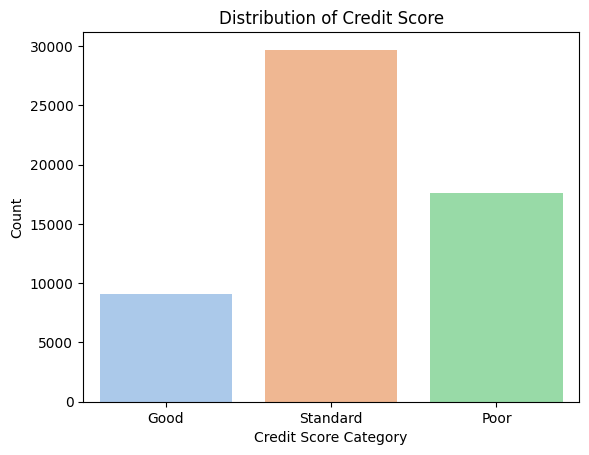

In [15]:
# 1. Distribution of Credit Score (Target variable)
sns.countplot(data=train_df, x='Credit_Score', palette='pastel')
plt.title("Distribution of Credit Score")
plt.xlabel("Credit Score Category")
plt.ylabel("Count")
plt.show()

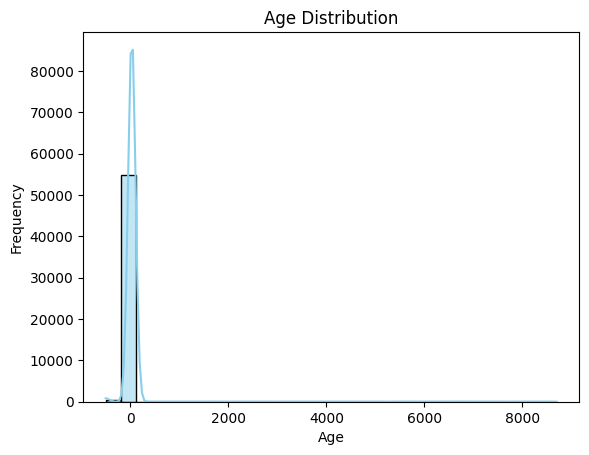

In [16]:
# 2. Age distribution with KDE
sns.histplot(train_df['Age'], kde=True, bins=30, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

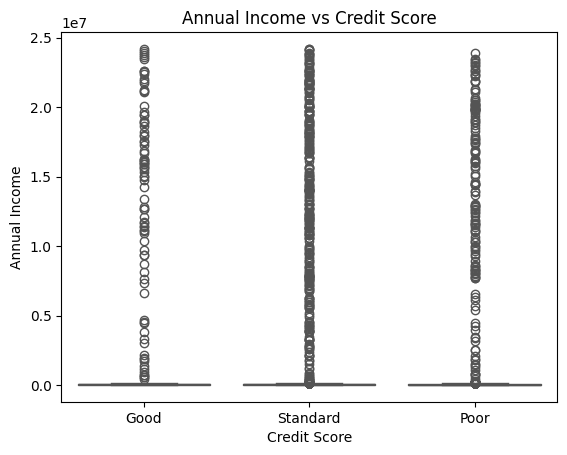

In [17]:
# 3. Annual Income vs Credit Score
sns.boxplot(data=train_df, x='Credit_Score', y='Annual_Income', palette='muted')
plt.title("Annual Income vs Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Annual Income")
plt.show()

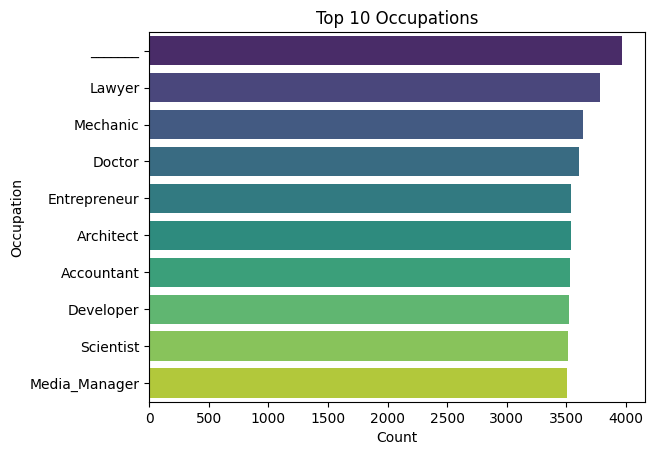

In [18]:
# 4. Occupation distribution (Top 10)
top_jobs = train_df['Occupation'].value_counts().nlargest(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index, palette='viridis')
plt.title("Top 10 Occupations")
plt.xlabel("Count")
plt.ylabel("Occupation")
plt.show()

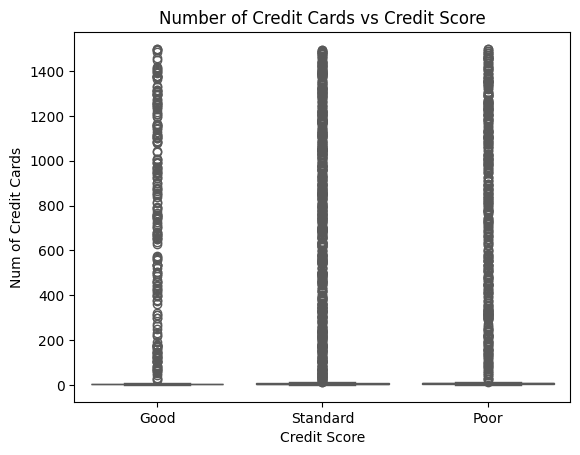

In [19]:
# 5. Number of Credit Cards vs Credit Score
sns.boxplot(data=train_df, x='Credit_Score', y='Num_Credit_Card', palette='Set2')
plt.title("Number of Credit Cards vs Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Num of Credit Cards")
plt.show()

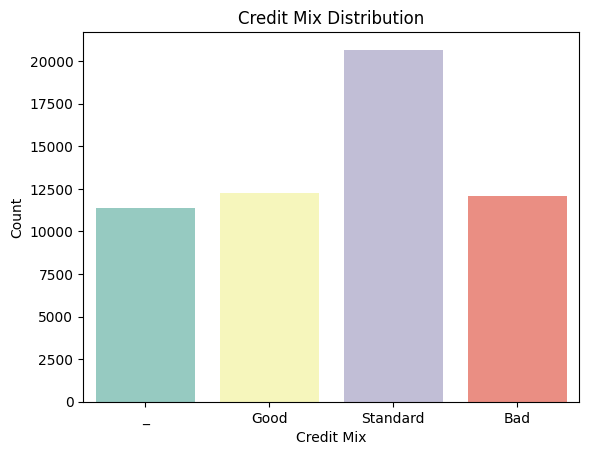

In [20]:
# 6. Credit Mix Countplot
sns.countplot(data=train_df, x='Credit_Mix', palette='Set3')
plt.title("Credit Mix Distribution")
plt.xlabel("Credit Mix")
plt.ylabel("Count")
plt.show()

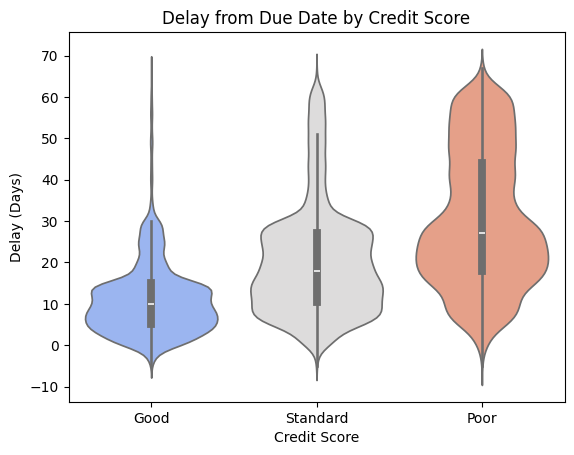

In [21]:
# 7. Delay from Due Date vs Credit Score
sns.violinplot(data=train_df, x='Credit_Score', y='Delay_from_due_date', palette='coolwarm')
plt.title("Delay from Due Date by Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Delay (Days)")
plt.show()

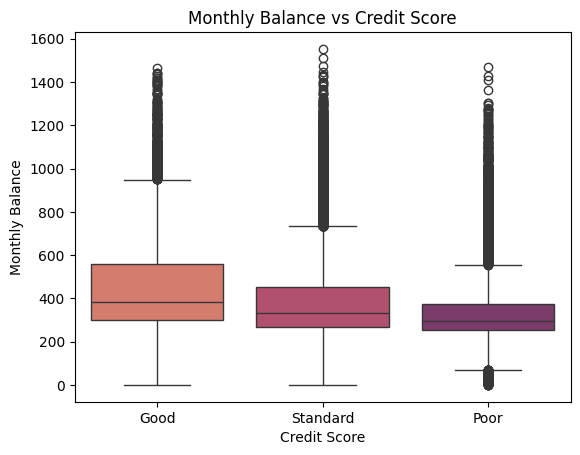

In [22]:
# 8. Monthly Balance vs Credit Score
sns.boxplot(data=train_df, x='Credit_Score', y='Monthly_Balance', palette='flare')
plt.title("Monthly Balance vs Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Monthly Balance")
plt.show()

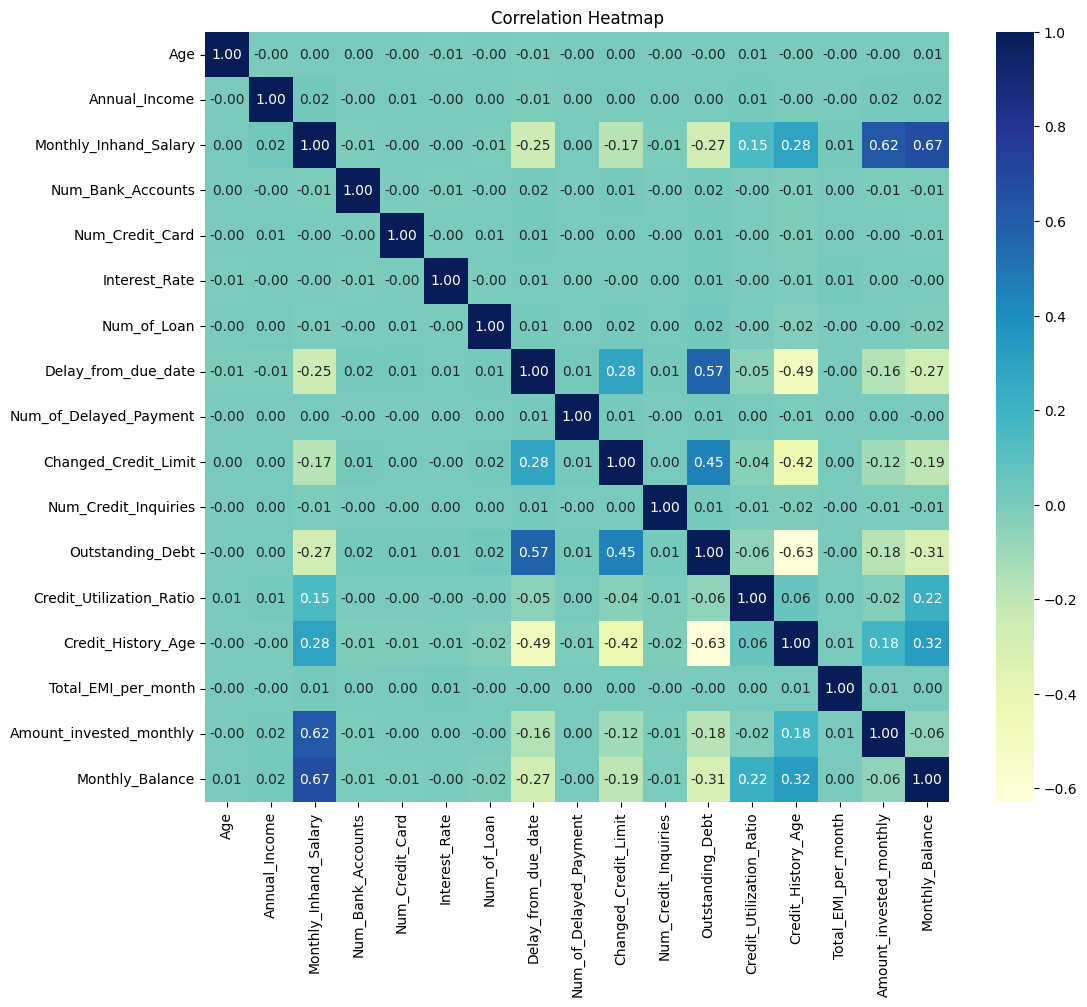

In [23]:
# 9. Correlation Heatmap for Numerical Features
plt.figure(figsize=(12, 10))
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Feature Engineering

In [25]:
# Create new feature: Total_Accounts
train_df['Total_Accounts'] = train_df['Num_Bank_Accounts'] + train_df['Num_Credit_Card']

In [26]:
# Encode categorical columns
label_enc_cols = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

le = LabelEncoder()
for col in label_enc_cols:
    train_df[col] = le.fit_transform(train_df[col])

In [27]:
# Encode target variable
train_df['Credit_Score'] = train_df['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})

In [28]:
# Feature Scaling
scaler = StandardScaler()

scaled_cols = train_df.select_dtypes(include=['float64', 'int64']).drop('Credit_Score', axis=1).columns
train_df[scaled_cols] = scaler.fit_transform(train_df[scaled_cols])

In [29]:
# Final dataset for ML
X = train_df.drop('Credit_Score', axis=1)
y = train_df['Credit_Score']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building and Evaluation

In [31]:
# Model 1: Logistic Regression
logreg = LogisticRegression(max_iter=1000)

In [32]:
# Train Model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
# Testing Model
y_pred_logreg = logreg.predict(X_test)

In [34]:
# Model Evaluation
print(" Logistic Regression ")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_logreg, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_logreg, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

 Logistic Regression 
Accuracy: 0.6026936026936027
Precision: 0.602811630811267
Recall: 0.6026936026936027
F1 Score: 0.5874607505365441

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.46      0.54      3592
           1       0.60      0.78      0.68      5847
           2       0.53      0.32      0.40      1847

    accuracy                           0.60     11286
   macro avg       0.59      0.52      0.54     11286
weighted avg       0.60      0.60      0.59     11286



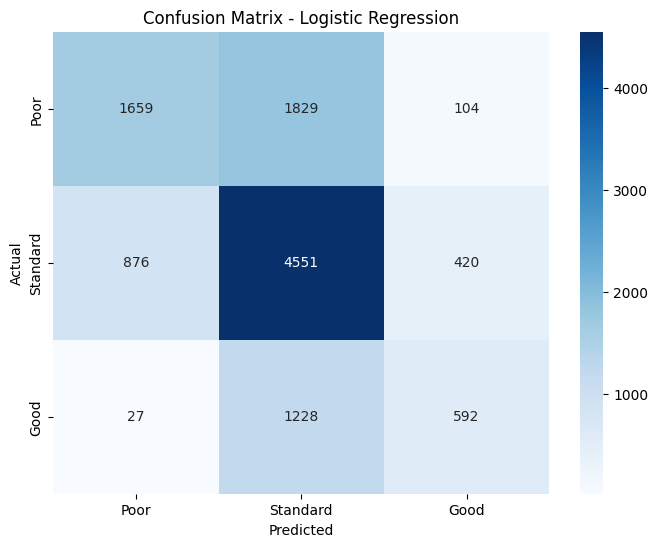

In [35]:
# confusion matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
# Model 2: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [37]:
# Train Model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# Test Model
y_pred_rf = rf.predict(X_test)

In [39]:
# Model Evaluation
print("\n Random Forest ")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


 Random Forest 
Accuracy: 0.7838915470494418
Precision: 0.7831194271020554
Recall: 0.7838915470494418
F1 Score: 0.7830990546811394

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      3592
           1       0.79      0.81      0.80      5847
           2       0.74      0.67      0.70      1847

    accuracy                           0.78     11286
   macro avg       0.78      0.76      0.77     11286
weighted avg       0.78      0.78      0.78     11286



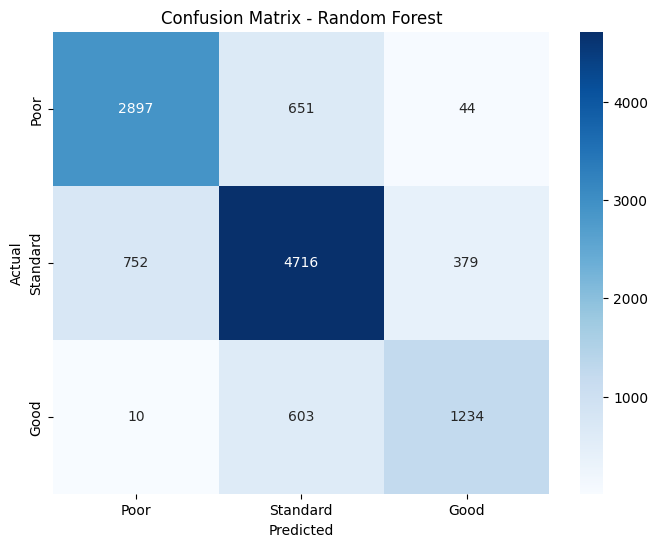

In [40]:
# confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# Model 3: Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [42]:
# Train Model
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [43]:
# Test Model
y_pred_gb = gb.predict(X_test)

In [44]:
# Model Evaluation
print("\n Gradient Boosting ")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_gb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_gb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))


 Gradient Boosting 
Accuracy: 0.7075137338295233
Precision: 0.7087313159527007
Recall: 0.7075137338295233
F1 Score: 0.706449353590059

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.66      0.70      3592
           1       0.71      0.77      0.74      5847
           2       0.60      0.59      0.60      1847

    accuracy                           0.71     11286
   macro avg       0.69      0.67      0.68     11286
weighted avg       0.71      0.71      0.71     11286



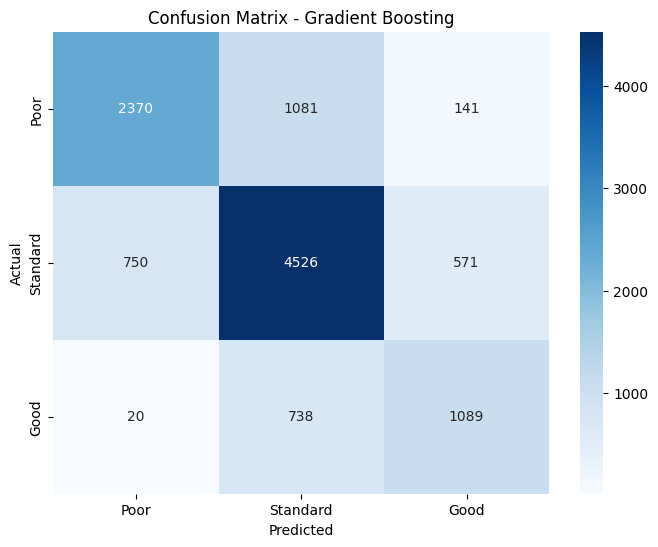

In [45]:
# confusion matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
# Model 4: K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)

In [47]:
# Train Model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
# Test Model
y_pred_knn = knn.predict(X_test)

In [49]:
# Model Evaluation
print("\n K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_knn, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


 K-Nearest Neighbors
Accuracy: 0.6196172248803827
Precision: 0.6128980385567414
Recall: 0.6196172248803827
F1 Score: 0.6137219727611719

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61      3592
           1       0.65      0.71      0.68      5847
           2       0.50      0.36      0.42      1847

    accuracy                           0.62     11286
   macro avg       0.59      0.56      0.57     11286
weighted avg       0.61      0.62      0.61     11286



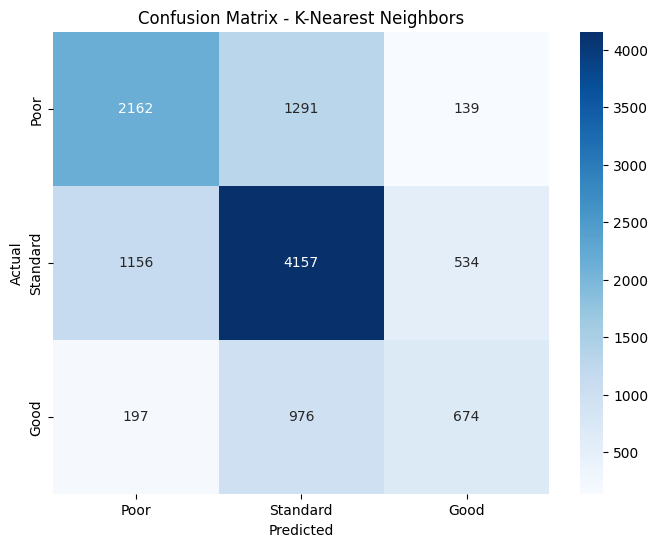

In [50]:
# confusion matrix for K-Nearest Neighbors
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
# Model 5: XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [52]:
# Train Model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [53]:
# Test Model
y_pred_xgb = xgb.predict(X_test)

In [54]:
# Model Evaluation
print("\n XGBoost Classifier ")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\n Classification Report:\n", classification_report(y_test, y_pred_xgb))


 XGBoost Classifier 
Accuracy: 0.753765727449938
Precision: 0.75332294575047
Recall: 0.753765727449938
F1 Score: 0.753318831906528

 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      3592
           1       0.76      0.79      0.78      5847
           2       0.69      0.66      0.67      1847

    accuracy                           0.75     11286
   macro avg       0.74      0.73      0.74     11286
weighted avg       0.75      0.75      0.75     11286



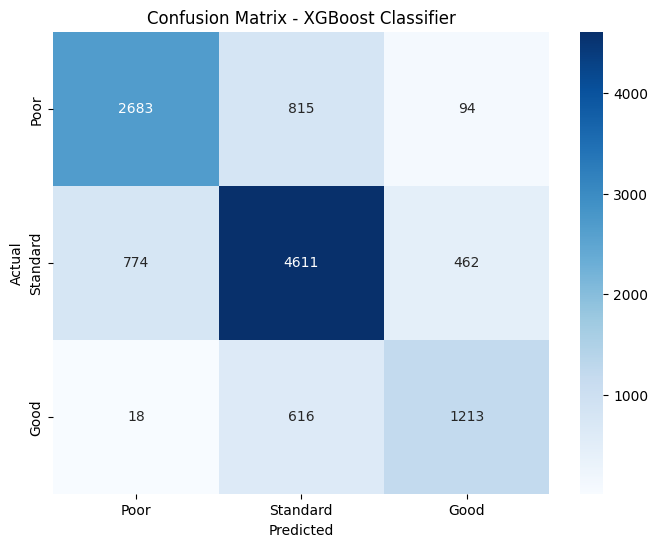

In [55]:
# confusion matrix for XGBoost Classifier
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Comparision

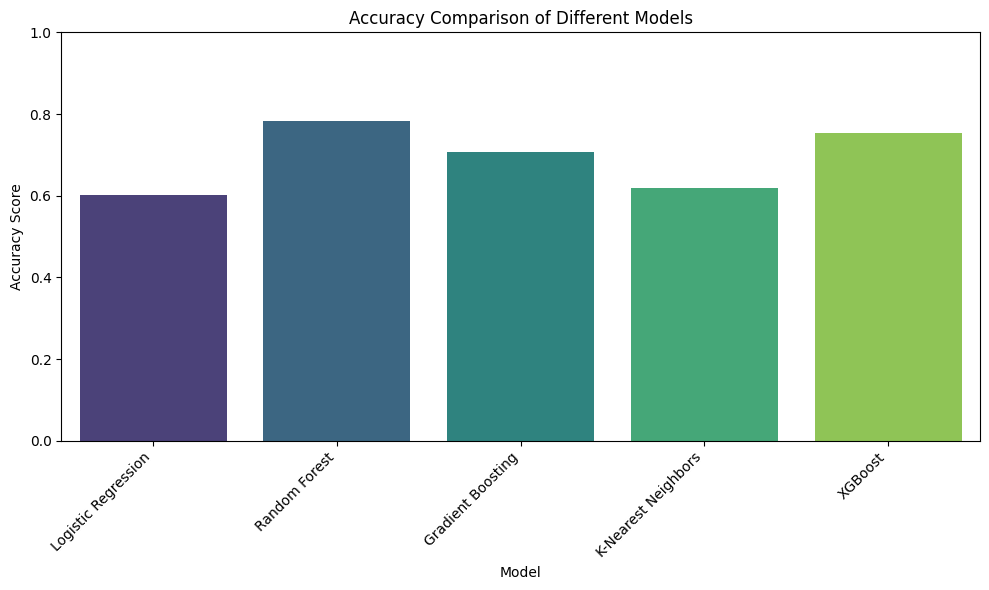

In [56]:
# Compile the accuracy scores
model_accuracies = {'Logistic Regression': accuracy_score(y_test, y_pred_logreg),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'Gradient Boosting': accuracy_score(y_test, y_pred_gb),
    'K-Nearest Neighbors': accuracy_score(y_test, y_pred_knn),
    'XGBoost': accuracy_score(y_test, y_pred_xgb)}

# Plotting the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='viridis')
plt.ylim(0, 1)
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [57]:
model_to_use = rf # Choose the trained Random Forest model
y_pred = model_to_use.predict(X_test)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
inverse_credit_score_mapping = {0: 'Poor', 1: 'Standard', 2: 'Good'}
results_df['Actual'] = results_df['Actual'].map(inverse_credit_score_mapping)
results_df['Predicted'] = results_df['Predicted'].map(inverse_credit_score_mapping)

# Print the first few rows of the results DataFrame
print("Actual vs Predicted Credit Scores :")
print(results_df.head(10))

Actual vs Predicted Credit Scores :
     Actual Predicted
0      Good      Good
1  Standard  Standard
2  Standard  Standard
3  Standard      Poor
4      Poor      Poor
5  Standard  Standard
6  Standard  Standard
7      Poor      Poor
8      Poor      Poor
9  Standard  Standard
